1. Importing libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'BnwaKGEameaHnxeat'

2.	Find a data set to work and import it into your Jupyter notebook. 

In [3]:
# Importing the Federal Reserve Economic Data "Unemployed" variable.

data = quandl.get('FRED/UNEMPLOY')

In [6]:
data.head()

,Value
Date,
1948-01-01,2034.0
1948-02-01,2328.0
1948-03-01,2399.0
1948-04-01,2386.0
1948-05-01,2118.0


In [7]:
data.shape

(889, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

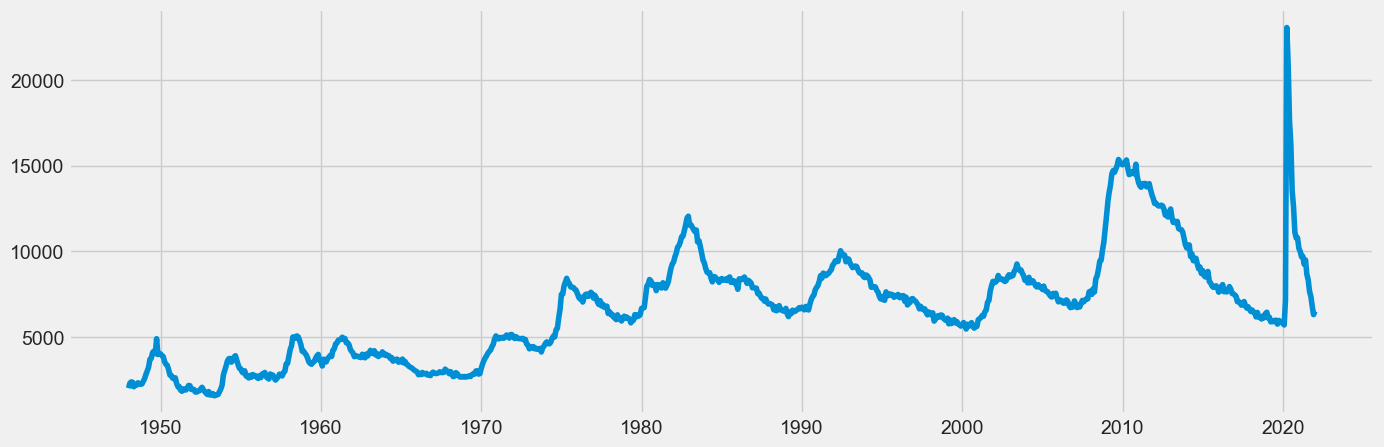

In [10]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here.

plt.plot(data)

3. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [13]:
data_2.tail()

,Date,Value
884,2021-09-01,7666.0
885,2021-10-01,7375.0
886,2021-11-01,6802.0
887,2021-12-01,6319.0
888,2022-01-01,6513.0


In [14]:
data_sub = data_2.loc[(data_2['Date'] >= '1992-01-01') & (data_2['Date'] < '2021-12-01')]

The time range from 1992 to 2021 was selected to capture a substantial period, including economic cycles, policy changes, and major events, providing a comprehensive perspective on the U.S. unemployment rate.

In [16]:
data_sub.tail()

,Date,Value
882,2021-07-01,8671.0
883,2021-08-01,8339.0
884,2021-09-01,7666.0
885,2021-10-01,7375.0
886,2021-11-01,6802.0


In [17]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1992-01-01,9283.0
1992-02-01,9454.0
1992-03-01,9460.0
1992-04-01,9415.0
1992-05-01,9744.0


4. Create a line chart of your data

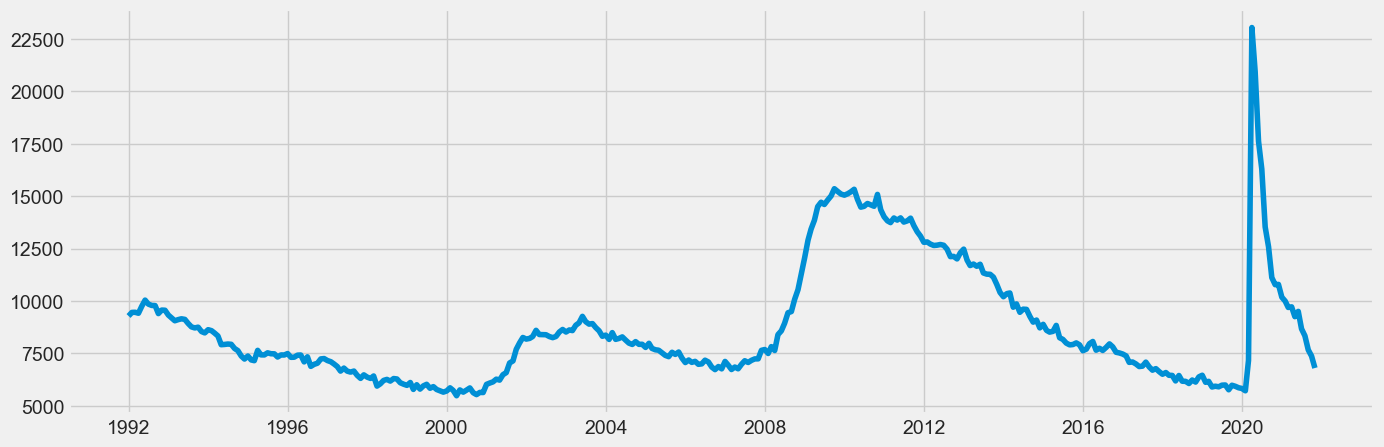

In [18]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [19]:
# Check for missing values

data_sub.isnull().sum()

Value    0
dtype: int64

In [20]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

18

In [21]:
data_sub.drop_duplicates(inplace=True)

In [22]:
dups = data_sub.duplicated()
dups.sum()

0

5.	Decompose the data’s components.

In [31]:
data_sub.index = pd.to_datetime(data_sub.index)

In [32]:
decomposition = sm.tsa.seasonal_decompose(data_sub['Value'], model='additive', period=12)  # Assuming a yearly seasonality

In [33]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

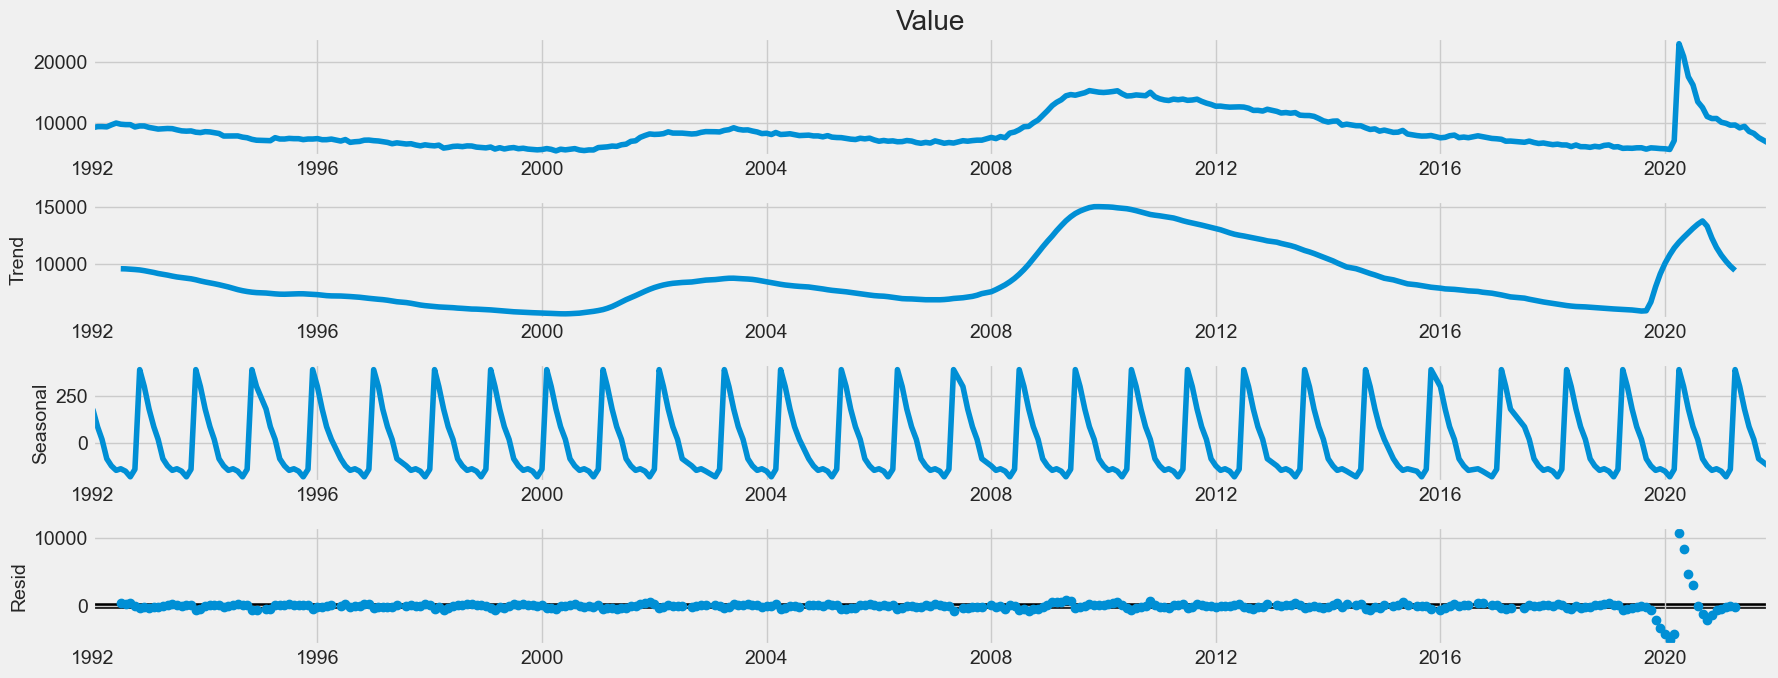

In [34]:
# Plot the separate components

decomposition.plot()
plt.show()

The U.S. unemployment trend between 1992-2001 was influenced by economic expansions and policy changes, with a generally declining rate. The 2008 financial crisis caused a spike in unemployment, followed by various economic challenges, while COVID-19 pandemic in 2020 led to widespread job losses and a subsequent recovery.

6.	Conduct a Dickey-Fuller test to check for stationarity.

H0: The data is non-stationary (presence of a unit root)
H1: The data is stationary (no unit root)

In [35]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

In [36]:
# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.068907
p-value                          0.028941
Number of Lags Used              0.000000
Number of Observations Used    340.000000
Critical Value (1%)             -3.449730
Critical Value (5%)             -2.870079
Critical Value (10%)            -2.571319
dtype: float64


The test statistic -3.068907, is more negative than the critical values at the 5%, and 10% significance levels. Additionally, the test statistic is less than the critical values.
Since the test statistic is less than the critical values, and the p-value (p<0.05) which is satisfactory, I, therefore, reject the null hypothesis.

9.	Check your data’s autocorrelations

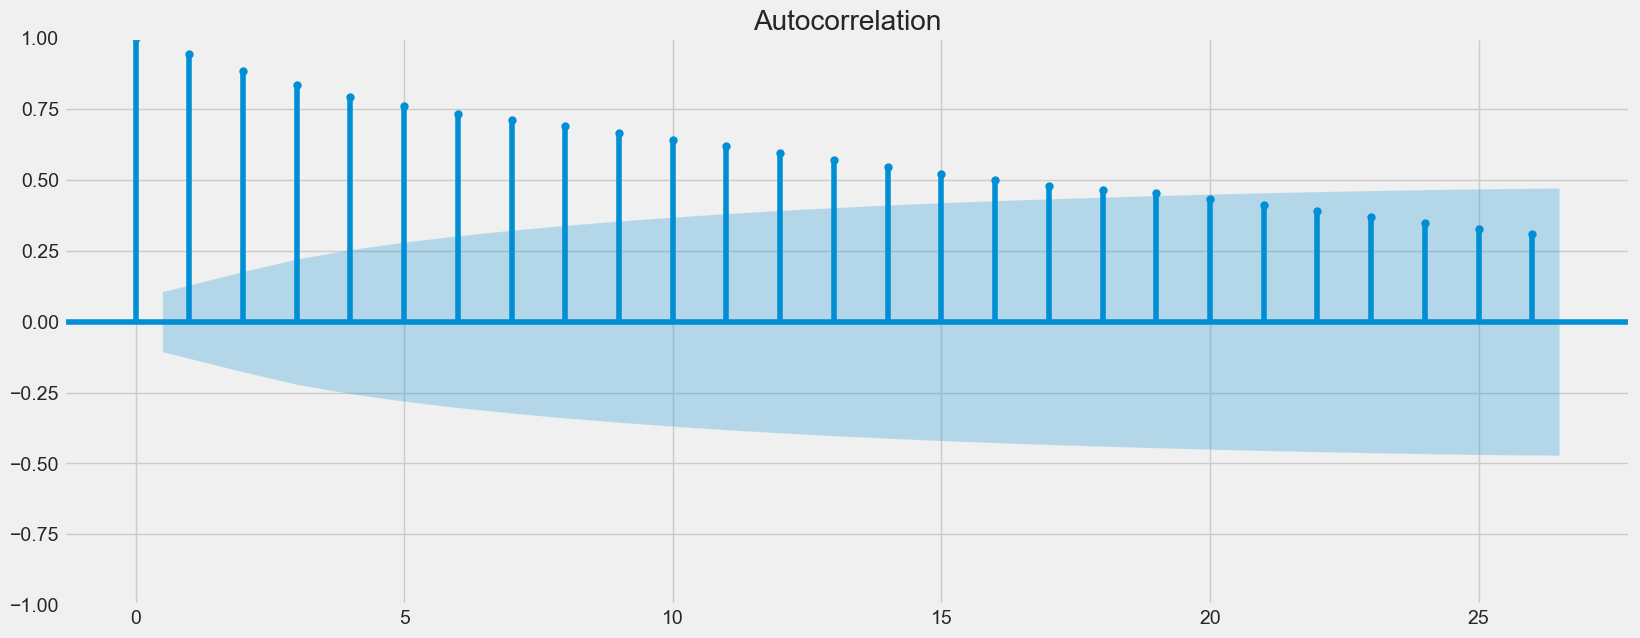

In [50]:
# Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()